# test_companion

Задание :  
  
Вам нужно построить скоринговую модель (модель прогноза и принятия решений), для того, чтобы автоматически решать - кому из клиентов выдавать кредит, а кому нет.  
  
Модель должна предсказывать тип кредита ("Хороший" или "Плохой") при помощи информации о клиенте (Пол, Возраст) и информации о кредитной истории клиента (Просрочки по его историческим кредитам).  
  
Модель может быть составлена в любом виде (рекомендуемый вариант - Логистическая регрессия).  
  
Желательно сделать обучение модели на одной части данных, а тестирование модели на другой части, и показать метрики качества модели (рекомендуемый вариант - ROC-AUC, Gini index).  
  
Результат :  
  
Отправить результаты нужно в виде :  
  
1) Код создания модели (рекомендуемый вариан т - jupyter notebook, .ipynb)  
  
2) Результат тестирования в любом формате  

## Импорт библиотек

In [1]:
try:
    import catboost
except ImportError:
    !pip install catboost


In [2]:
import pandas as pd
import re as re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 
import numpy as np

from catboost import CatBoostClassifier
from catboost import Pool, cv

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, precision_recall_curve, accuracy_score
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


## Загрузка данных


In [3]:
credit_info = pd.read_excel("Credit Info.xlsx")
customer_info = pd.read_excel("Customer Info.xlsx")
history_info = pd.read_excel("History Info.xlsx")


### credit_info

In [4]:
credit_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Credit ID          1000 non-null   int64         
 1   Customer ID        1000 non-null   int64         
 2   Loan Created Date  1000 non-null   datetime64[ns]
 3   Type Credit        1000 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 31.4+ KB


In [5]:
credit_info.head()

,Credit ID,Customer ID,Loan Created Date,Type Credit
0,857000,483,2020-09-05,Normal
1,695553,843,2021-05-20,Normal
2,992484,1801,2021-07-02,Normal
3,964325,296,2021-09-25,Normal
4,602834,694,2021-04-21,Normal


In [6]:
credit_info.describe(include = 'all', datetime_is_numeric=True)

,Credit ID,Customer ID,Loan Created Date,Type Credit
count,1000.000000,1000.000000,1000,1000
unique,NaN,NaN,NaN,2
top,NaN,NaN,NaN,Normal
freq,NaN,NaN,NaN,897
mean,503401.862000,979.259000,2021-06-29 05:03:50.400000,NaN
min,4639.000000,1.000000,2020-01-01 00:00:00,NaN
25%,255464.250000,476.000000,2020-09-26 18:00:00,NaN
50%,498307.000000,974.500000,2021-07-10 12:00:00,NaN
75%,748615.500000,1469.000000,2022-03-16 00:00:00,NaN
max,999987.000000,1997.000000,2022-12-30 00:00:00,NaN


In [7]:
credit_info.duplicated().sum()

0

Credit ID: Уникальный идентификатор кредита.    
Customer ID: Уникальный идентификатор клиента.  
Loan Created Date: Дата создания кредита.  
Type Credit: Тип кредита, который может быть либо "Normal", либо "Problem".  

Пропуски отсутствуют, дубликаты отсутствуют. Минимальная дата 2020-01-01 0:00:00	последняя дата 2022-12-30 00:00:00. Два уникальных значения в типах кредита	

### customer_info

In [8]:
customer_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Customer ID  798 non-null    int64         
 1   Sex          798 non-null    object        
 2   Birthday     798 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 18.8+ KB


In [9]:
customer_info.describe(include = 'all', datetime_is_numeric=True)

,Customer ID,Sex,Birthday
count,798.000000,798,798
unique,NaN,2,NaN
top,NaN,Man,NaN
freq,NaN,412,NaN
mean,969.021303,NaN,1971-07-13 02:51:25.714285712
min,1.000000,NaN,1940-01-06 00:00:00
25%,453.250000,NaN,1955-05-27 12:00:00
50%,966.500000,NaN,1971-02-15 00:00:00
75%,1460.500000,NaN,1987-08-10 18:00:00
max,1997.000000,NaN,2005-12-16 00:00:00


In [10]:
customer_info.duplicated().sum()

0

In [11]:
customer_info.head()

,Customer ID,Sex,Birthday
0,1,Man,2000-07-14
1,3,Man,2003-03-04
2,16,Man,1989-03-04
3,17,Woman,1956-01-17
4,18,Man,1993-10-23


Customer ID: Уникальный идентификатор клиента.    
Sex - пол   
Birthday - день рождение клиента  

Пропуски отсутствуют, дубликаты отсутствуют. Минимальная дата дня рождения 1940-01-06 00:00:00	последняя дата 2005-12-16 00:00:00(По каждому клиенту можно посчитать возраст на момент выдачи кредита). Пол только два значение Man and Woman


### history_info

In [12]:
history_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   History Note ID  1500 non-null   int64
 1   Customer ID      1500 non-null   int64
 2   Overdues         1500 non-null   int64
dtypes: int64(3)
memory usage: 35.3 KB


In [13]:
history_info

,History Note ID,Customer ID,Overdues
0,0,499,0
1,1,461,0
2,2,516,0
3,3,138,0
4,4,1770,0
...,...,...,...
1495,1495,1287,0
1496,1496,194,86
1497,1497,48,0
1498,1498,686,0


In [14]:
history_info.describe(include = 'all', datetime_is_numeric=True)

,History Note ID,Customer ID,Overdues
count,1500.000000,1500.000000,1500.000000
mean,749.500000,940.132667,11.480000
std,433.157015,586.060076,23.990386
min,0.000000,1.000000,0.000000
25%,374.750000,431.000000,0.000000
50%,749.500000,918.500000,0.000000
75%,1124.250000,1449.250000,0.000000
max,1499.000000,1997.000000,90.000000


In [15]:
history_info.query("`Customer ID` == 201")

,History Note ID,Customer ID,Overdues
282,282,201,90
832,832,201,63
1178,1178,201,0
1211,1211,201,90
1229,1229,201,0
1426,1426,201,87
1436,1436,201,0


In [16]:
credit_info.query("`Customer ID` == 201")

,Credit ID,Customer ID,Loan Created Date,Type Credit
975,531107,201,2021-03-14,Problem


In [17]:
history_info.duplicated().sum()

0

History Note ID	 - Это уникальный идентификатор записи в истории кредитования. Каждая запись представляет собой конкретный случай, когда клиент имел просрочку по оплате кредита.  
  
Customer ID	-  Это уникальный идентификатор клиента. Этот идентификатор связывает запись просрочки с конкретным клиентом.  
    
Overdues - Этот признак представляет собой количество дней просрочек, которые были у данного клиента в данном случае. В контексте этого файла, одна запись соответствует  просрочке. 

Пропуски отсутствуют, дубликаты отсутствуют. 

## Объединение данных

In [18]:
history_info.tail()

,History Note ID,Customer ID,Overdues
1495,1495,1287,0
1496,1496,194,86
1497,1497,48,0
1498,1498,686,0
1499,1499,510,0


In [19]:
history_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   History Note ID  1500 non-null   int64
 1   Customer ID      1500 non-null   int64
 2   Overdues         1500 non-null   int64
dtypes: int64(3)
memory usage: 35.3 KB


In [20]:
# Группировка данных истории по ID клиента, подсчет общего числа просрочек и количества записей о просрочках
overdues_sum = history_info.groupby('Customer ID')['Overdues'].sum().reset_index().rename(columns={'Overdues': 'Overdues_Sum'})
overdues_count = history_info.groupby('Customer ID').size().reset_index().rename(columns={0: 'Overdues_Count'})

# Объединение информации о сумме и количестве просрочек
overdues = pd.merge(overdues_sum, overdues_count, on="Customer ID")

# Объединение информации о клиентах с историей просрочек
customer_info = pd.merge(customer_info, overdues, on="Customer ID", how='left')

# Объединение данных кредитов и информации о клиентах
data = pd.merge(credit_info, customer_info, on="Customer ID")




In [21]:
data.head()

,Credit ID,Customer ID,Loan Created Date,Type Credit,Sex,Birthday,Overdues_Sum,Overdues_Count
0,857000,483,2020-09-05,Normal,Woman,1959-06-15,NaN,NaN
1,695553,843,2021-05-20,Normal,Man,1960-09-25,32.0,1.0
2,755310,843,2020-08-24,Normal,Man,1960-09-25,32.0,1.0
3,992484,1801,2021-07-02,Normal,Woman,1982-12-24,32.0,1.0
4,964325,296,2021-09-25,Normal,Man,1982-08-17,NaN,NaN


### Обобщение


Исходя из текущего описания данных, у нас нет прямого способа связать просрочки с конкретными кредитами. В нашей таблице history_info у нас есть информация о просрочках ('Overdues') и идентификаторе клиента ('Customer ID'), но нет уникального идентификатора кредита ('Credit ID') для связи с просрочками.  
  
Если бы у нас была такая информация, мы могли бы использовать ее для более точного объединения данных. Например, если бы у нас был столбец 'Credit ID' в таблице history_info, мы могли бы просто выполнить операцию объединения (merge) с использованием идентификатора кредита.  
  
Мы вынуждены предположить, что общая история просрочек клиента применима ко всем его кредитам.  

## Предобработка

In [22]:
data.head()

,Credit ID,Customer ID,Loan Created Date,Type Credit,Sex,Birthday,Overdues_Sum,Overdues_Count
0,857000,483,2020-09-05,Normal,Woman,1959-06-15,NaN,NaN
1,695553,843,2021-05-20,Normal,Man,1960-09-25,32.0,1.0
2,755310,843,2020-08-24,Normal,Man,1960-09-25,32.0,1.0
3,992484,1801,2021-07-02,Normal,Woman,1982-12-24,32.0,1.0
4,964325,296,2021-09-25,Normal,Man,1982-08-17,NaN,NaN


In [23]:
# Заполнение пропущенных значений в просрочках
data['Overdues_Sum'] = data['Overdues_Sum'].fillna(0)
data['Overdues_Count'] = data['Overdues_Count'].fillna(0)
data['Overdues_Sum'] = data['Overdues_Sum'].astype(int)
data['Overdues_Count'] = data['Overdues_Count'].astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Credit ID          1000 non-null   int64         
 1   Customer ID        1000 non-null   int64         
 2   Loan Created Date  1000 non-null   datetime64[ns]
 3   Type Credit        1000 non-null   object        
 4   Sex                1000 non-null   object        
 5   Birthday           1000 non-null   datetime64[ns]
 6   Overdues_Sum       1000 non-null   int64         
 7   Overdues_Count     1000 non-null   int64         
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 70.3+ KB


In [24]:
data.drop_duplicates().duplicated().sum()

0

In [25]:
#Приведем название столбцов к змеиному регистру
data.columns = [re.sub(r"\b([A-Z])", r"_\1", col).lower() for col in data.columns]
data.columns = [col.lstrip("_") for col in data.columns]
data.columns = [re.sub(r'\s_', '_', i) for i in data.columns]

data.columns

Index(['credit_id', 'customer_id', 'loan_created_date', 'type_credit', 'sex',
       'birthday', 'overdues_sum', 'overdues_count'],
      dtype='object')

In [26]:
data.describe(include='all', datetime_is_numeric=True)

,credit_id,customer_id,loan_created_date,type_credit,sex,birthday,overdues_sum,overdues_count
count,1000.000000,1000.000000,1000,1000,1000,1000,1000.000000,1000.00000
unique,NaN,NaN,NaN,2,2,NaN,NaN,NaN
top,NaN,NaN,NaN,Normal,Man,NaN,NaN,NaN
freq,NaN,NaN,NaN,897,519,NaN,NaN,NaN
mean,503401.862000,979.259000,2021-06-29 05:03:50.400000,NaN,NaN,1971-11-03 09:50:24,21.246000,1.85900
min,4639.000000,1.000000,2020-01-01 00:00:00,NaN,NaN,1940-01-06 00:00:00,0.000000,0.00000
25%,255464.250000,476.000000,2020-09-26 18:00:00,NaN,NaN,1956-01-21 00:00:00,0.000000,1.00000
50%,498307.000000,974.500000,2021-07-10 12:00:00,NaN,NaN,1971-03-06 00:00:00,0.000000,2.00000
75%,748615.500000,1469.000000,2022-03-16 00:00:00,NaN,NaN,1987-08-20 00:00:00,34.000000,3.00000
max,999987.000000,1997.000000,2022-12-30 00:00:00,NaN,NaN,2005-12-16 00:00:00,330.000000,7.00000


In [27]:
#Удалим неинформативные столбцы, не нужные для модели credit_id, customer_id
data = data.drop(['credit_id', 'customer_id'], axis=1).copy()
data.head()



,loan_created_date,type_credit,sex,birthday,overdues_sum,overdues_count
0,2020-09-05,Normal,Woman,1959-06-15,0,0
1,2021-05-20,Normal,Man,1960-09-25,32,1
2,2020-08-24,Normal,Man,1960-09-25,32,1
3,2021-07-02,Normal,Woman,1982-12-24,32,1
4,2021-09-25,Normal,Man,1982-08-17,0,0


### Обобщение

1. Обработали пропуски в overdues, замнили на 0
2. Удалили неинформативные столбцы, не нужные для модели credit_id, customer_id
3. Привели столбцы к змеиному регистру
4. Дубликаты отсутствуют как и пропуски

## Анализ данных и добавление дополнительных призанков

In [28]:
#Некоторые тенденции могут быть циклическими на ежегодной или ежемесячной основе 
data['loan_created_month'] = data['loan_created_date'].dt.month
data['loan_created_day'] = data['loan_created_date'].dt.day
# Создание столбца "Loan Season" на основе месяца взятия кредита
data['loan_season'] = data['loan_created_date'].dt.month.map({
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Autumn',
    10: 'Autumn',
    11: 'Autumn',
    12: 'Winter'
})
season_mapping = {
    'Winter': 1,
    'Spring': 2,
    'Summer': 3,
    'Autumn': 4
}

data['loan_season'] = data['loan_season'].map(season_mapping)


In [29]:
# Возраст клиента на момент создания кредит
data['age_at_loan'] = (data['loan_created_date'] - data['birthday']).dt.days // 365
data = data.drop(['birthday',], axis=1).copy()
#Удалим неинформативные столбцы, не нужные для модели 
data = data.drop(['loan_created_date'], axis=1).copy()
data.head()

data['age_at_loan'].unique()

array([61, 60, 59, 38, 39, 68, 26, 34, 40, 56, 55, 64, 43, 44, 42, 15, 46,
       18, 69, 50, 62, 48, 75, 45, 25, 27, 49, 65, 63, 73, 77, 76, 37, 30,
       17, 79, 51, 57, 16, 21, 58, 66, 71, 74, 72, 54, 52, 67, 19, 20, 70,
       35, 36, 24, 23, 33, 53, 29, 41, 47, 28, 78, 80, 82, 81, 31, 14, 32,
       22])

In [30]:
#Удалим все данные младше 18 лет 
data = data.query('age_at_loan >= 18')

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 964 entries, 0 to 999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   type_credit         964 non-null    object
 1   sex                 964 non-null    object
 2   overdues_sum        964 non-null    int64 
 3   overdues_count      964 non-null    int64 
 4   loan_created_month  964 non-null    int64 
 5   loan_created_day    964 non-null    int64 
 6   loan_season         964 non-null    int64 
 7   age_at_loan         964 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 67.8+ KB


In [32]:
# Среднее количество дней просрочки на одну просрочку
data['average_overdue'] = data['overdues_sum'] / data['overdues_count']
data['average_overdue'].fillna(0, inplace=True)


In [33]:
#кодирование категориального признака 'sex'
data['sex'] = data['sex'].map({'Woman': 0, 'Man': 1})
data.head()

,type_credit,sex,overdues_sum,overdues_count,loan_created_month,loan_created_day,loan_season,age_at_loan,average_overdue
0,Normal,0,0,0,9,5,4,61,0.0
1,Normal,1,32,1,5,20,2,60,32.0
2,Normal,1,32,1,8,24,3,59,32.0
3,Normal,0,32,1,7,2,3,38,32.0
4,Normal,1,0,0,9,25,4,39,0.0


In [34]:
# целевой признак 'type_credit' содержит категории "Normal" и "Problem", мы можете выполнить бинарное кодирование этого признака
data['type_credit'] = data['type_credit'].replace({'Normal': 0, 'Problem': 1})


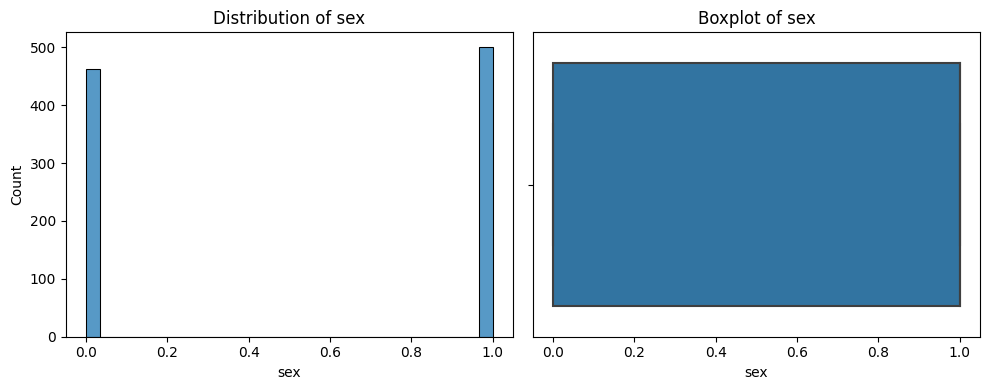

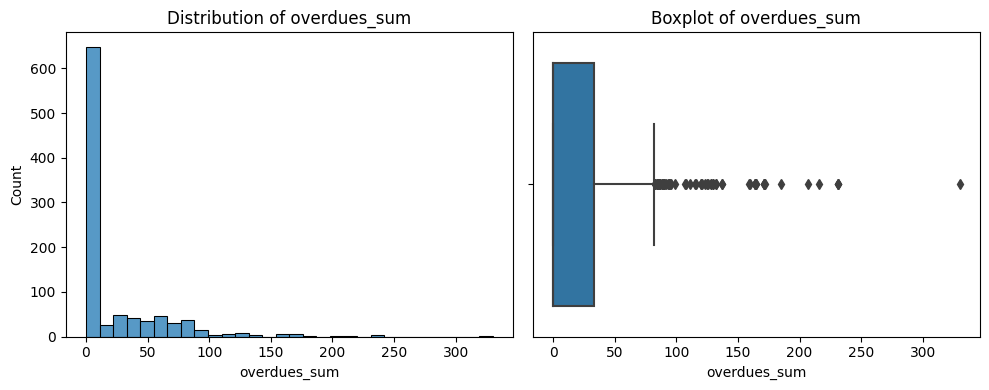

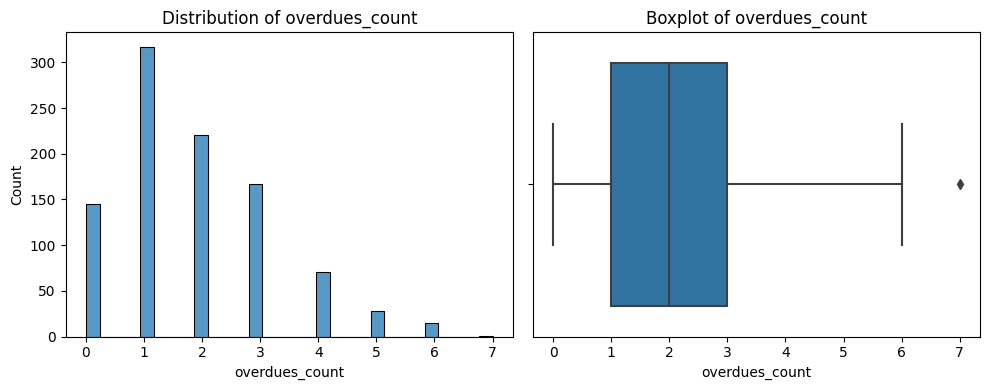

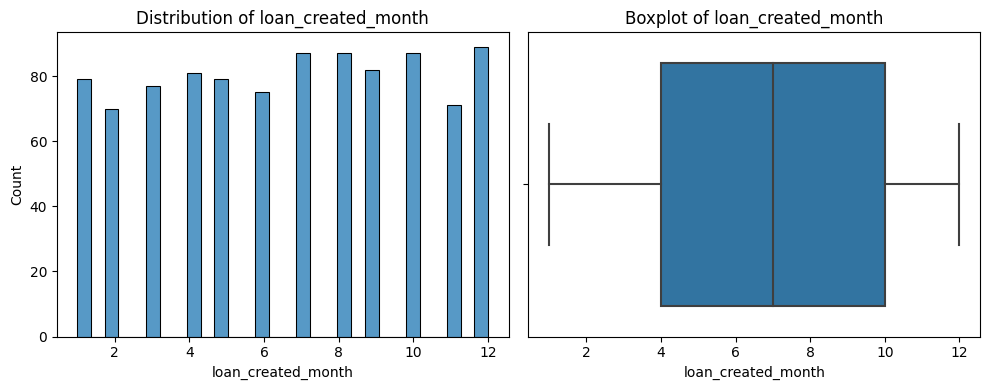

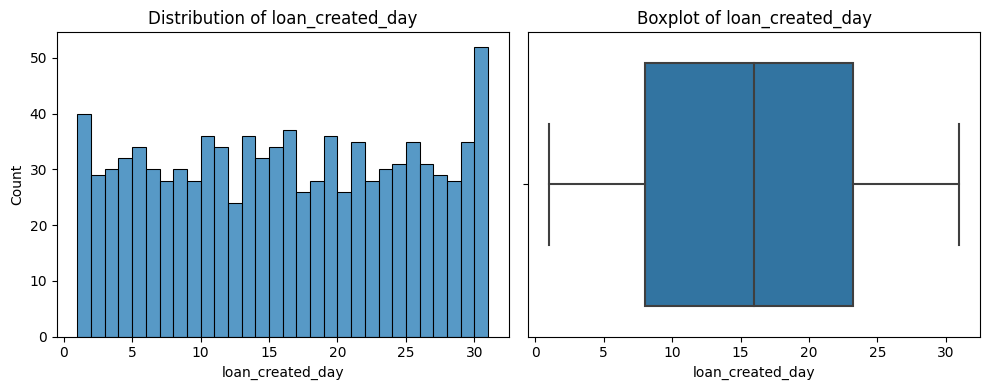

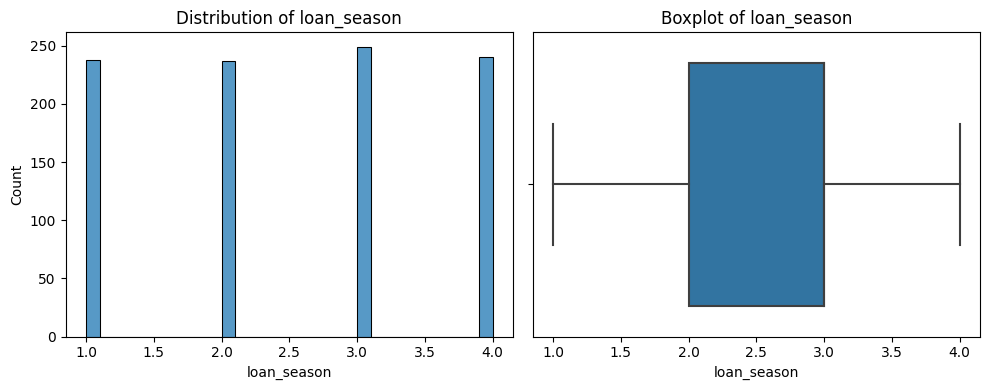

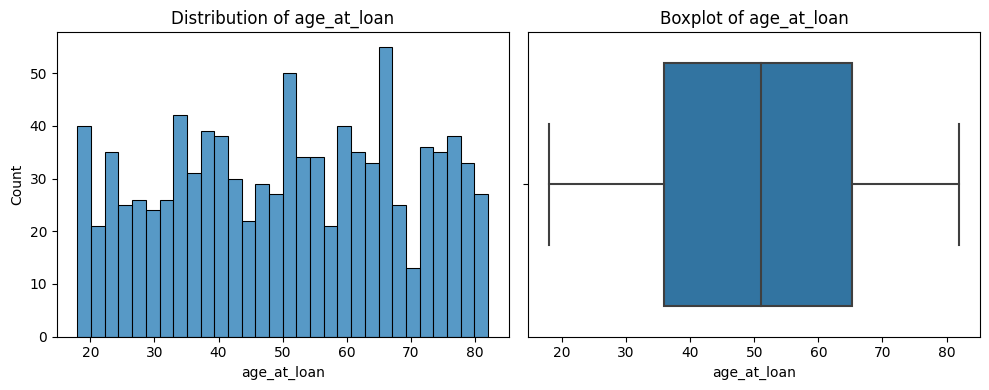

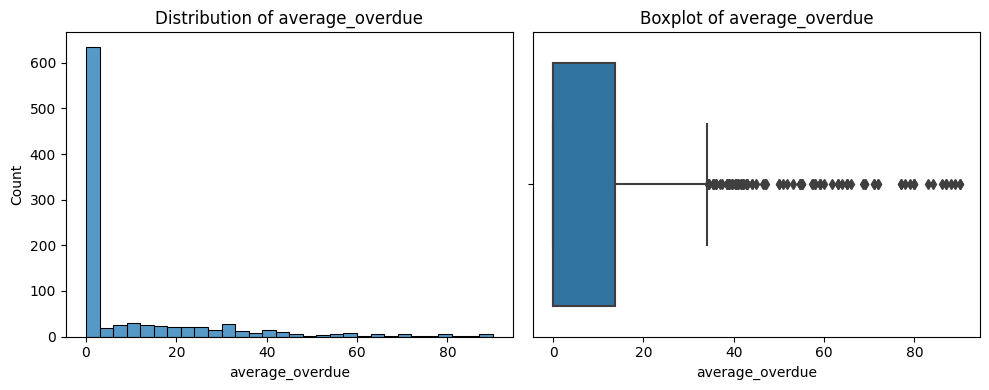

In [35]:
# Список всех числовых столбцов, кроме целевой переменной
features = [col for col in data.select_dtypes(include=[np.number]).columns if col != 'type_credit']

# Построение графика для каждого признака
for feature in features:
    plt.figure(figsize=(10, 4))
    
    # Построение гистограммы
    plt.subplot(1, 2, 1)
    sns.histplot(data[feature], bins=30, kde=False)
    plt.title(f'Distribution of {feature}')
    
    # Построение ящика с усами для оценки выбросов
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[feature])
    plt.title(f'Boxplot of {feature}')
    
    plt.tight_layout()
    plt.show() 



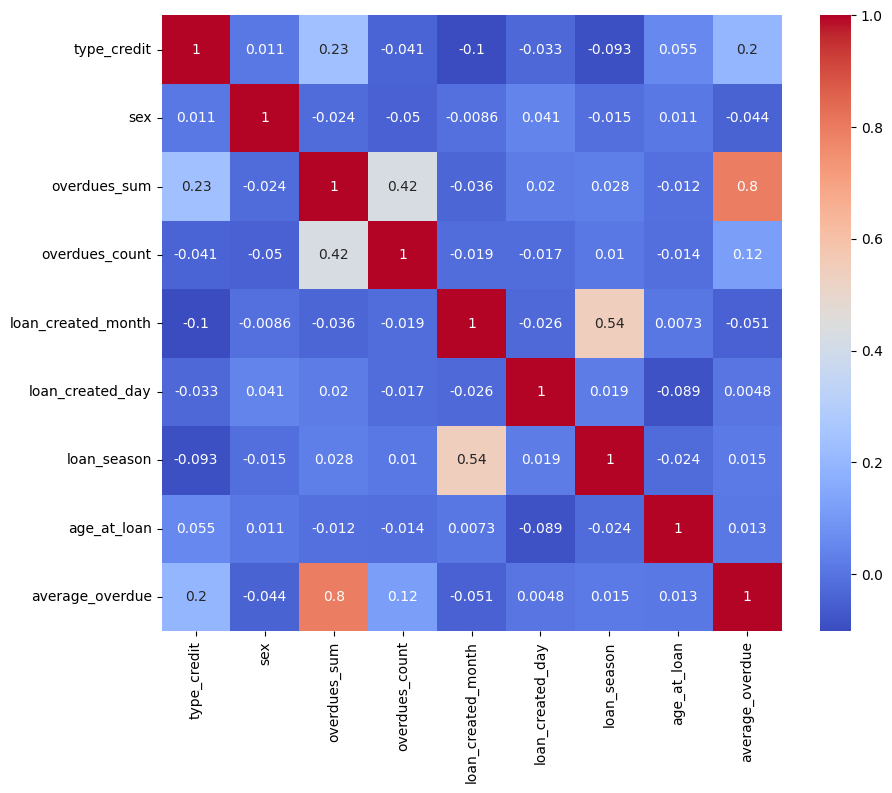

In [36]:
# Проверим корреляцию
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [37]:
data.groupby('sex')['type_credit'].count()# рассмотрим целевой признак

sex
0    463
1    501
Name: type_credit, dtype: int64

In [38]:
data.groupby('sex')['type_credit'].sum()# количество проблемных кредитов

sex
0    46
1    53
Name: type_credit, dtype: int64

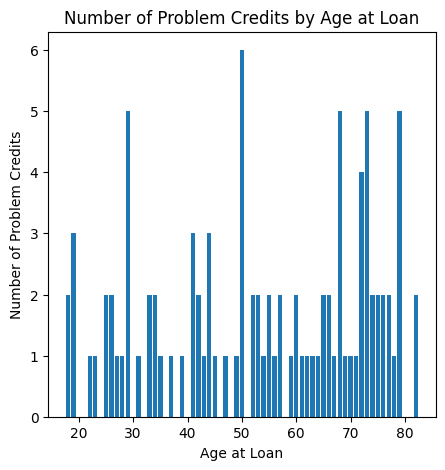

In [39]:
problem_credits_per_age = data.groupby('age_at_loan')['type_credit'].sum()# количество проблемных кредитов по возрасту

plt.figure(figsize=(5, 5))
plt.bar(problem_credits_per_age.index, problem_credits_per_age.values)
plt.xlabel('Age at Loan')
plt.ylabel('Number of Problem Credits')
plt.title('Number of Problem Credits by Age at Loan')
plt.show()

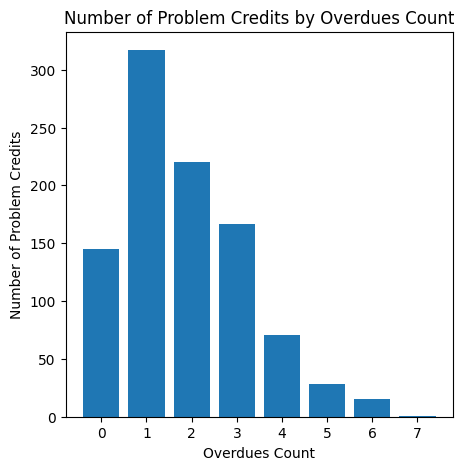

In [40]:
problem_credits_per_overdues = data.groupby('overdues_count')['type_credit'].count()

plt.figure(figsize=(5, 5))
plt.bar(problem_credits_per_overdues.index, problem_credits_per_overdues.values)
plt.xlabel('Overdues Count')
plt.ylabel('Number of Problem Credits')
plt.title('Number of Problem Credits by Overdues Count')
plt.show()


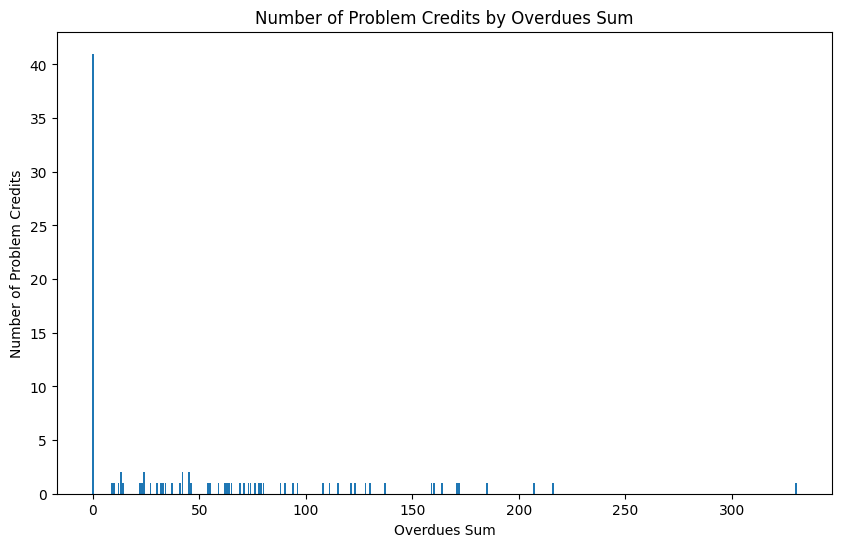

In [41]:
problem_credits_per_overdues_sum = data.groupby('overdues_sum')['type_credit'].sum()

plt.figure(figsize=(10, 6))
plt.bar(problem_credits_per_overdues_sum.index, problem_credits_per_overdues_sum.values)
plt.xlabel('Overdues Sum')
plt.ylabel('Number of Problem Credits')
plt.title('Number of Problem Credits by Overdues Sum')
plt.show()


### Вывод 

1. У большинства клиентов отсутствуют просрочки по платежам (то есть 'overdues_sum' равен 0). Это нормально и соответствует общей динамике кредитования: большинство клиентов погашают свои кредиты в срок, а проблемные кредиты — это относительно редкий случай.
2. Больше всего проблемных кредитов у 50-летних
3. Клиенты, которые допустили хотя бы одну просрочку, могут стать менее дисциплинированными в погашении кредита, что увеличивает вероятность проблем с кредитом.
4. Присутствуют выбросы
5. Удалили кредиты, где возраст заемщика меньше 18 лет

## Основная часть 

In [42]:
data

,type_credit,sex,overdues_sum,overdues_count,loan_created_month,loan_created_day,loan_season,age_at_loan,average_overdue
0,0,0,0,0,9,5,4,61,0.000000
1,0,1,32,1,5,20,2,60,32.000000
2,0,1,32,1,8,24,3,59,32.000000
3,0,0,32,1,7,2,3,38,32.000000
4,0,1,0,0,9,25,4,39,0.000000
...,...,...,...,...,...,...,...,...,...
995,0,1,0,1,4,27,2,22,0.000000
996,0,1,79,6,10,15,4,28,13.166667
997,1,1,0,0,3,30,2,64,0.000000
998,0,0,0,1,10,29,4,31,0.000000


 ### Разобьем данные на выборки

In [43]:
# отделим 20% данных для тестовой выборки выборки (для проверки модели)
target = data['type_credit']
features = data.drop(['type_credit'] , axis=1)
features_other, features_test, target_other, target_test = train_test_split(
    features, target, test_size=0.2, random_state=453)

In [44]:
# отделим 25% данных(от other) для разделения на обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(
    features_other, target_other, test_size=0.25, random_state=453)

In [45]:
print('Размер обучающей выборки', len(features_train))
print('Размер валидационной выборки', len(features_valid))
print('Размер тестовой выборки', len(features_test))

Размер обучающей выборки 578
Размер валидационной выборки 193
Размер тестовой выборки 193


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 964 entries, 0 to 999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type_credit         964 non-null    int64  
 1   sex                 964 non-null    int64  
 2   overdues_sum        964 non-null    int64  
 3   overdues_count      964 non-null    int64  
 4   loan_created_month  964 non-null    int64  
 5   loan_created_day    964 non-null    int64  
 6   loan_season         964 non-null    int64  
 7   age_at_loan         964 non-null    int64  
 8   average_overdue     964 non-null    float64
dtypes: float64(1), int64(8)
memory usage: 75.3 KB


### Масштабирование

In [47]:
features.columns

Index(['sex', 'overdues_sum', 'overdues_count', 'loan_created_month',
       'loan_created_day', 'loan_season', 'age_at_loan', 'average_overdue'],
      dtype='object')

In [48]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train), columns = features.columns)
features_valid = pd.DataFrame(scaler.transform(features_valid), columns = features.columns)
features_test = pd.DataFrame(scaler.transform(features_test), columns = features.columns)

In [49]:
features_test

,sex,overdues_sum,overdues_count,loan_created_month,loan_created_day,loan_season,age_at_loan,average_overdue
0,-1.038815,-0.575681,0.808658,0.745125,-1.536644,1.380922,-1.011531,-0.574793
1,0.962635,5.081891,3.013395,1.319368,1.248668,1.380922,-1.399534,1.431763
2,0.962635,-0.575681,-0.661167,0.745125,0.357368,1.380922,-1.344105,-0.574793
3,0.962635,-0.306273,0.073746,0.458003,1.360080,0.481065,1.371916,-0.288143
4,0.962635,-0.575681,0.073746,0.458003,-1.313819,0.481065,-0.568099,-0.574793
...,...,...,...,...,...,...,...,...
188,0.962635,0.159069,0.073746,0.458003,1.025843,0.481065,-1.288676,0.206982
189,0.962635,-0.575681,-1.396079,0.170882,-1.313819,0.481065,0.651339,-0.574793
190,0.962635,1.457126,-0.661167,0.170882,-0.088282,0.481065,-0.512670,3.751029
191,0.962635,-0.575681,0.808658,1.606489,-0.645344,-1.318648,0.374194,-0.574793


### Дисбаланс классов

In [50]:
data.groupby('type_credit')['type_credit'].count()# рассмотрим целевой признак. Каждый 9 кредит проблемный. Наблюдается дисбаланс классов

type_credit
0    865
1     99
Name: type_credit, dtype: int64

В большинстве моделей есть параметр для взвешивания классов во время обучения модели. Например, в случае логистической регрессии, мы можем установить параметр class_weight='balanced', и модель автоматически придаст больший вес миноритарному классу.

### Обучение и выбор моделей

In [51]:
#для удобства вывода в дальнейшем - соберем показатели в списки

tabl_model = []
tabl_prec = []
tabl_not = []
tabl_roc_auc = []
tabl_gini = []


### class_weight='balanced'

#### CatBoostClassifier

In [52]:
model = CatBoostClassifier(
    iterations=1000, 
    depth=5, 
    learning_rate=0.1, 
    custom_loss=['AUC', 'Accuracy'],
    random_seed=453,
    verbose=False
)

model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))


F1: 0.16666666666666669
AUC_ROC = 0.684

Gini Index = 0.369



In [53]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('class_weight')


#### LogisticRegression

In [54]:
model = LogisticRegression(penalty='l1', solver='liblinear', random_state=453, class_weight='balanced')
model.fit(features_train, target_train) 
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1: 0.28169014084507044
AUC_ROC = 0.825

Gini Index = 0.649



In [55]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc, 2))
tabl_model.append('LogisticRegression')
tabl_not.append('class_weight')

#### Модель Дерево решений 

In [56]:
%%time
1 + 1
best_model = None
best_result = 0
for depth in range(1, 15):
	model = DecisionTreeClassifier(max_depth=depth, random_state=453, class_weight='balanced') 
	model.fit(features_train, target_train) 
	predicted_valid = model.predict(features_valid) 
	result = f1_score(target_valid, predicted_valid) 
	if result > best_result:
		best_model = model
		best_result = result

print("F1 лучшей модели:", best_result)
print("max_depth лучшей модели:", best_model)

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1 лучшей модели: 0.2376237623762376
max_depth лучшей модели: DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=453)
AUC_ROC = 0.709

Gini Index = 0.418

CPU times: user 95.3 ms, sys: 0 ns, total: 95.3 ms
Wall time: 96.3 ms


In [57]:
tabl_prec.append(round((best_result), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('class_weight')

#### Модель случайный лес

In [58]:
%%time
1 + 1

model = RandomForestClassifier(class_weight='balanced', max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30,random_state=453)

model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))


gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1: 0.25
AUC_ROC = 0.709

Gini Index = 0.418

CPU times: user 71.5 ms, sys: 108 µs, total: 71.6 ms
Wall time: 72.2 ms


In [59]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('class_weight')


In [60]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Gini Index':tabl_gini, 'Notice': tabl_not}).sort_values(by='ROC-AUC', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Gini Index,Notice
0,LogisticRegression,0.28,0.82,0.65,class_weight
1,DecisionTreeClassifier,0.24,0.71,0.42,class_weight
2,RandomForestClassifier,0.25,0.71,0.42,class_weight
3,CatBoostClassifier,0.17,0.68,0.37,class_weight


### upsampling. Увеличение выборки

In [61]:
oversample = SMOTE(random_state=453)
features_upsampled, target_upsampled = oversample.fit_resample(features_train, target_train)
print('Размер увеличенной валидационной выборки', len(features_upsampled))

Размер увеличенной валидационной выборки 1020


#### Модель Логистическая регрессия

In [62]:
model = LogisticRegression(penalty='l1', solver='liblinear', random_state=453, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1: 0.3
AUC_ROC = 0.836

Gini Index = 0.673



In [63]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('LogisticRegression')
tabl_not.append('upsampling')

#### Модель Дерево решений 

In [64]:
%%time
1 + 1
best_model = None
best_result = 0
for depth in range(1, 15):
	model = DecisionTreeClassifier(max_depth=depth)
	model.fit(features_upsampled, target_upsampled)
	predicted_valid = model.predict(features_valid) 
	result = f1_score(target_valid, predicted_valid) 
	if result > best_result:
		best_model = model
		best_result = result

print("F1 лучшей модели:", best_result)
print("max_depth лучшей модели:", best_model)

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1 лучшей модели: 0.22988505747126434
max_depth лучшей модели: DecisionTreeClassifier(max_depth=2)
AUC_ROC = 0.675

Gini Index = 0.351

CPU times: user 107 ms, sys: 144 µs, total: 107 ms
Wall time: 113 ms


In [65]:
tabl_prec.append(round((best_result), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('upsampling')

#### Модель случайный лес. 

In [66]:
%%time
1 + 1
model = RandomForestClassifier(max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30, random_state=453)

model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1: 0.1
AUC_ROC = 0.751

Gini Index = 0.502

CPU times: user 87.6 ms, sys: 0 ns, total: 87.6 ms
Wall time: 87.7 ms


In [67]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('upsampling')

#### CatBoostClassifier

In [68]:
model = CatBoostClassifier(
    iterations=1000, 
    depth=5, 
    learning_rate=0.1, 
    custom_loss=['AUC', 'Accuracy'],
    random_seed=453,
    verbose=False
)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

auc_roc = roc_auc_score(target_valid, predicted_valid)
print('ROC-AUC:', auc_roc)

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1: 0.0689655172413793
ROC-AUC: 0.4968164794007491
Gini Index = -0.006



In [69]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('upsampling')

In [70]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Gini Index':tabl_gini, 'Notice': tabl_not}).sort_values(by='ROC-AUC', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Gini Index,Notice
0,LogisticRegression,0.30,0.84,0.67,upsampling
1,LogisticRegression,0.28,0.82,0.65,class_weight
2,RandomForestClassifier,0.10,0.75,0.50,upsampling
3,DecisionTreeClassifier,0.24,0.71,0.42,class_weight
4,RandomForestClassifier,0.25,0.71,0.42,class_weight
5,CatBoostClassifier,0.17,0.68,0.37,class_weight
6,DecisionTreeClassifier,0.23,0.68,0.35,upsampling
7,CatBoostClassifier,0.07,0.50,-0.01,upsampling


### downsampling. Уменьшение выборки

In [71]:
downsample = RandomUnderSampler(random_state=12345)

In [72]:
features_downsampled, target_downsampled = downsample.fit_resample(features_train, target_train)

In [73]:
print('Размер уменьшенной валидационной выборки', len(features_downsampled))

Размер уменьшенной валидационной выборки 136


#### Модель Логистическая регрессия

In [74]:
model = LogisticRegression(penalty='l1', solver='liblinear', random_state=453, class_weight='balanced')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1: 0.24390243902439024
AUC_ROC = 0.793

Gini Index = 0.585



In [75]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('LogisticRegression')
tabl_not.append('downsampled')

#### Модель Дерево решений 

In [76]:
%%time
1 + 1
best_model = None
best_result = 0
for depth in range(1, 15):
	model = DecisionTreeClassifier(max_depth=depth) 
	model.fit(features_downsampled, target_downsampled) 
	predicted_valid = model.predict(features_valid) 
	result = f1_score(target_valid, predicted_valid) 
	if result > best_result:
		best_model = model
		best_result = result

print("F1 лучшей модели:", best_result)
print("max_depth лучшей модели:", best_model)

probabilities_valid = best_model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1 лучшей модели: 0.2682926829268293
max_depth лучшей модели: DecisionTreeClassifier(max_depth=3)
AUC_ROC = 0.720

Gini Index = 0.440

CPU times: user 71.4 ms, sys: 2 µs, total: 71.4 ms
Wall time: 71.3 ms


In [77]:
tabl_prec.append(round((best_result), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('downsampled')

#### Модель случайный лес

In [78]:
%%time
1 + 1
model = RandomForestClassifier(max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30, random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1: 0.25
AUC_ROC = 0.706

Gini Index = 0.412

CPU times: user 66.7 ms, sys: 735 µs, total: 67.4 ms
Wall time: 65.5 ms


In [79]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('downsampled')

#### CatBoostClassifier

In [80]:
model = CatBoostClassifier(
    iterations=1000, 
    depth=5, 
    learning_rate=0.1, 
    custom_loss=['AUC', 'Accuracy'],
    random_seed=453,
    verbose=False
)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("AUC_ROC = {:.3f}\n".format(auc_roc))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

F1: 0.2150537634408602
AUC_ROC = 0.629

Gini Index = 0.258



In [81]:
tabl_prec.append(round(f1_score(target_valid, predicted_valid), 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('downsampled')

In [82]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Gini Index':tabl_gini, 'Notice': tabl_not}).sort_values(by='ROC-AUC', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Gini Index,Notice
0,LogisticRegression,0.30,0.84,0.67,upsampling
1,LogisticRegression,0.28,0.82,0.65,class_weight
2,LogisticRegression,0.24,0.79,0.59,downsampled
3,RandomForestClassifier,0.10,0.75,0.50,upsampling
4,DecisionTreeClassifier,0.27,0.72,0.44,downsampled
5,DecisionTreeClassifier,0.24,0.71,0.42,class_weight
6,RandomForestClassifier,0.25,0.71,0.42,class_weight
7,RandomForestClassifier,0.25,0.71,0.41,downsampled
8,CatBoostClassifier,0.17,0.68,0.37,class_weight
9,DecisionTreeClassifier,0.23,0.68,0.35,upsampling


### Изменение порога клалификации

Граница, где заканчивается отрицательный класс и начинается положительный, называется порогом (threshold). По умолчанию он равен 0.5, но его можно поменять.

#### Модель Логистическая регрессия

In [83]:
model = LogisticRegression(penalty='l1', solver='liblinear', random_state=453, class_weight='balanced')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0
for threshold in np.arange(0, 1, 0.05):
    predicted_valid = probabilities_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    F1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

Порог = 0.00 | Точность = 0.078, Полнота = 1.000, F1-мера = 0.144
Порог = 0.05 | Точность = 0.078, Полнота = 1.000, F1-мера = 0.144
Порог = 0.10 | Точность = 0.080, Полнота = 1.000, F1-мера = 0.149
Порог = 0.15 | Точность = 0.084, Полнота = 1.000, F1-мера = 0.155
Порог = 0.20 | Точность = 0.090, Полнота = 1.000, F1-мера = 0.165
Порог = 0.25 | Точность = 0.098, Полнота = 1.000, F1-мера = 0.179
Порог = 0.30 | Точность = 0.109, Полнота = 1.000, F1-мера = 0.197
Порог = 0.35 | Точность = 0.122, Полнота = 1.000, F1-мера = 0.217
Порог = 0.40 | Точность = 0.137, Полнота = 0.867, F1-мера = 0.236
Порог = 0.45 | Точность = 0.156, Полнота = 0.800, F1-мера = 0.261
Порог = 0.50 | Точность = 0.179, Полнота = 0.667, F1-мера = 0.282
Порог = 0.55 | Точность = 0.222, Полнота = 0.667, F1-мера = 0.333
Порог = 0.60 | Точность = 0.286, Полнота = 0.533, F1-мера = 0.372
Порог = 0.65 | Точность = 0.333, Полнота = 0.467, F1-мера = 0.389
Порог = 0.70 | Точность = 0.429, Полнота = 0.400, F1-мера = 0.414
Порог = 0.

Для порога 0.7 самый высокий показатель F1 и ROC-AUC

In [84]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('LogisticRegression')
tabl_not.append('threshold=0.7')

In [85]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Gini Index':tabl_gini, 'Notice': tabl_not}).sort_values(by='ROC-AUC', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Gini Index,Notice
0,LogisticRegression,0.30,0.84,0.67,upsampling
1,LogisticRegression,0.28,0.82,0.65,class_weight
2,LogisticRegression,0.41,0.82,0.65,threshold=0.7
3,LogisticRegression,0.24,0.79,0.59,downsampled
4,RandomForestClassifier,0.10,0.75,0.50,upsampling
5,DecisionTreeClassifier,0.27,0.72,0.44,downsampled
6,DecisionTreeClassifier,0.24,0.71,0.42,class_weight
7,RandomForestClassifier,0.25,0.71,0.42,class_weight
8,RandomForestClassifier,0.25,0.71,0.41,downsampled
9,CatBoostClassifier,0.17,0.68,0.37,class_weight


#### Модель Дерево решений 

In [86]:
%%time
1 + 1
model = DecisionTreeClassifier(max_depth=5)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0
for threshold in np.arange(0, 1, 0.05):
    predicted_valid = probabilities_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    F1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1))

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

Порог = 0.00 | Точность = 0.064, Полнота = 0.800, F1-мера = 0.118
Порог = 0.05 | Точность = 0.097, Полнота = 0.467, F1-мера = 0.161
Порог = 0.10 | Точность = 0.136, Полнота = 0.400, F1-мера = 0.203
Порог = 0.15 | Точность = 0.100, Полнота = 0.133, F1-мера = 0.114
Порог = 0.20 | Точность = 0.067, Полнота = 0.067, F1-мера = 0.067
Порог = 0.25 | Точность = 0.067, Полнота = 0.067, F1-мера = 0.067
Порог = 0.30 | Точность = 0.100, Полнота = 0.067, F1-мера = 0.080
Порог = 0.35 | Точность = 0.100, Полнота = 0.067, F1-мера = 0.080
Порог = 0.40 | Точность = 0.100, Полнота = 0.067, F1-мера = 0.080
Порог = 0.45 | Точность = 0.111, Полнота = 0.067, F1-мера = 0.083
Порог = 0.50 | Точность = 0.000, Полнота = 0.000, F1-мера = 0.000
Порог = 0.55 | Точность = 0.000, Полнота = 0.000, F1-мера = 0.000
Порог = 0.60 | Точность = 0.000, Полнота = 0.000, F1-мера = 0.000
Порог = 0.65 | Точность = 0.000, Полнота = 0.000, F1-мера = 0.000
Порог = 0.70 | Точность = 0.000, Полнота = 0.000, F1-мера = 0.000
Порог = 0.

Для порога 0.1 самый высокий показатель F1

In [87]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('DecisionTreeClassifier')
tabl_not.append('threshold=0.1')

In [88]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Gini Index':tabl_gini, 'Notice': tabl_not}).sort_values(by='ROC-AUC', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Gini Index,Notice
0,LogisticRegression,0.30,0.84,0.67,upsampling
1,LogisticRegression,0.28,0.82,0.65,class_weight
2,LogisticRegression,0.41,0.82,0.65,threshold=0.7
3,LogisticRegression,0.24,0.79,0.59,downsampled
4,RandomForestClassifier,0.10,0.75,0.50,upsampling
5,DecisionTreeClassifier,0.27,0.72,0.44,downsampled
6,DecisionTreeClassifier,0.24,0.71,0.42,class_weight
7,RandomForestClassifier,0.25,0.71,0.42,class_weight
8,RandomForestClassifier,0.25,0.71,0.41,downsampled
9,CatBoostClassifier,0.17,0.68,0.37,class_weight


#### Модель случайный лес

In [89]:
%%time
1 + 1
model = RandomForestClassifier(max_depth=17, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=30, random_state=12345)

model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0 

for threshold in np.arange(0, 1, 0.05):
    predicted_valid = probabilities_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    F1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1)) 

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

Порог = 0.00 | Точность = 0.081, Полнота = 1.000, F1-мера = 0.149
Порог = 0.05 | Точность = 0.110, Полнота = 0.933, F1-мера = 0.197
Порог = 0.10 | Точность = 0.163, Полнота = 0.867, F1-мера = 0.274
Порог = 0.15 | Точность = 0.184, Полнота = 0.600, F1-мера = 0.281
Порог = 0.20 | Точность = 0.194, Полнота = 0.400, F1-мера = 0.261
Порог = 0.25 | Точность = 0.294, Полнота = 0.333, F1-мера = 0.312
Порог = 0.30 | Точность = 0.417, Полнота = 0.333, F1-мера = 0.370
Порог = 0.35 | Точность = 0.444, Полнота = 0.267, F1-мера = 0.333
Порог = 0.40 | Точность = 0.600, Полнота = 0.200, F1-мера = 0.300
Порог = 0.45 | Точность = 0.000, Полнота = 0.000, F1-мера = 0.000
Порог = 0.50 | Точность = 0.000, Полнота = 0.000, F1-мера = 0.000
Порог = 0.55 | Точность = 0.000, Полнота = 0.000, F1-мера = 0.000
Порог = 0.60 | Точность = 0.000, Полнота = 0.000, F1-мера = 0.000
Порог = 0.65 | Точность = 0.000, Полнота = 0.000, F1-мера = 0.000
Порог = 0.70 | Точность = 0.000, Полнота = 0.000, F1-мера = 0.000
Порог = 0.

Для порога 0.3 самый высокий показатель F1

In [90]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('RandomForestClassifier')
tabl_not.append('threshold=0.3')

In [91]:
%%time
1 + 1
model = CatBoostClassifier(verbose=50, random_state=12345)

model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

best_f1 = 0 

for threshold in np.arange(0, 0.4, 0.01):
    predicted_valid = probabilities_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    F1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(threshold, precision, recall, F1))
    if F1>best_f1:
        best_f1 = F1

auc_roc = roc_auc_score(target_valid, probabilities_valid)
print("ROC-AUC = {:.3f}".format(auc_roc))     
print("F1-мера = {:.3f}".format(best_f1)) 

gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))
tabl_gini.append(round(gini, 2))

Learning rate set to 0.008152
0:	learn: 0.6860177	total: 618us	remaining: 618ms
50:	learn: 0.4514805	total: 29.1ms	remaining: 541ms
100:	learn: 0.3570510	total: 60.4ms	remaining: 537ms
150:	learn: 0.3127330	total: 90.6ms	remaining: 510ms
200:	learn: 0.2855856	total: 121ms	remaining: 481ms
250:	learn: 0.2667041	total: 157ms	remaining: 470ms
300:	learn: 0.2504551	total: 193ms	remaining: 448ms
350:	learn: 0.2375136	total: 230ms	remaining: 425ms
400:	learn: 0.2267663	total: 268ms	remaining: 400ms
450:	learn: 0.2174430	total: 297ms	remaining: 362ms
500:	learn: 0.2080312	total: 328ms	remaining: 327ms
550:	learn: 0.1988707	total: 359ms	remaining: 292ms
600:	learn: 0.1906214	total: 389ms	remaining: 258ms
650:	learn: 0.1824246	total: 418ms	remaining: 224ms
700:	learn: 0.1744606	total: 451ms	remaining: 193ms
750:	learn: 0.1675062	total: 492ms	remaining: 163ms
800:	learn: 0.1605875	total: 525ms	remaining: 130ms
850:	learn: 0.1539830	total: 560ms	remaining: 98ms
900:	learn: 0.1480037	total: 593ms	

In [92]:
tabl_prec.append(round(best_f1, 2))
tabl_roc_auc.append(round(auc_roc,2))
tabl_model.append('CatBoostClassifier')
tabl_not.append('threshold=0.28')

In [93]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 'Gini Index':tabl_gini, 'Notice': tabl_not}).sort_values(by='ROC-AUC', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Gini Index,Notice
0,LogisticRegression,0.30,0.84,0.67,upsampling
1,LogisticRegression,0.28,0.82,0.65,class_weight
2,LogisticRegression,0.41,0.82,0.65,threshold=0.7
3,LogisticRegression,0.24,0.79,0.59,downsampled
4,RandomForestClassifier,0.37,0.78,0.57,threshold=0.3
5,CatBoostClassifier,0.38,0.76,0.52,threshold=0.28
6,RandomForestClassifier,0.10,0.75,0.50,upsampling
7,DecisionTreeClassifier,0.27,0.72,0.44,downsampled
8,DecisionTreeClassifier,0.24,0.71,0.42,class_weight
9,RandomForestClassifier,0.25,0.71,0.42,class_weight


### Вывод

<div class="alert alert-info"> <b>
У нас определилась самая удачная модели - LogisticRegression с лучшей F1-мерой и мерой ROC-AUC полученной с увеличенной выборкой. Попробуем подобрать для нее оптимальные гиперпараметры.

    1. Кроме того, мы выявили что при наличии дисбаланса для нашей задачи, лучше всего подходит увеличение выборки для LogisticRegression.
    2. class_weight показал себя тоже неплохо
</div>


### Подбор гиперпараметров

In [94]:
# Определение гиперпараметров для перебора
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga']}

# Создание экземпляра модели
model = LogisticRegression(random_state=453, class_weight='balanced')

# Инициализация GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='roc_auc', cv=5, n_jobs=-1)

# Обучение модели с перебором гиперпараметров
grid_search.fit(features_upsampled, target_upsampled)

# Вывод лучших параметров и метрики качества
print('Best parameters:', grid_search.best_params_)
print('Best ROC-AUC score:', grid_search.best_score_)

auc_roc = grid_search.best_score_
gini = 2 * auc_roc - 1
print("Gini Index = {:.3f}\n".format(gini))

Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Best ROC-AUC score: 0.7338908112264513
Gini Index = 0.468



## Проверяем модель на тестовой выборке

In [95]:
tabl_model = []
tabl_prec = []
tabl_not = []
tabl_roc_auc = []
tabl_gini = []
tabl_params = []

In [96]:
# Обучаем модель с лучшими параметрами
model_best = LogisticRegression(**grid_search.best_params_, random_state=453, class_weight='balanced')
model_best.fit(features_train, target_train)

# Получаем предсказания модели
predicted = model_best.predict(features_test)

# Получаем предсказанные вероятности
probabilities = model_best.predict_proba(features_test)[:, 1]

# Получаем ROC-AUC и Gini Index для предсказаний с учетом порога
roc_auc = roc_auc_score(target_test, probabilities)
gini = 2 * roc_auc - 1
print("ROC-AUC: {:.3f}".format(roc_auc))
print("Gini Index: {:.3f}".format(gini))


# Вычисляем и печатаем F1-score
f1 = f1_score(target_test, predicted)
print("F1-score: {:.3f}".format(f1))

ROC-AUC: 0.719
Gini Index: 0.439
F1-score: 0.225


In [97]:
tabl_prec.append(round(f1, 2))
tabl_roc_auc.append(round(roc_auc, 2))
tabl_model.append('LogisticRegression')
tabl_not.append('test')
tabl_gini.append(round(gini, 2))
tabl_params.append(grid_search.best_params_)


In [98]:
table_models = (pd.DataFrame({'Model':tabl_model, 'F1 score':tabl_prec, 'ROC-AUC':tabl_roc_auc, 
                              'Gini Index':tabl_gini, 'Notice': tabl_not, 'params':tabl_params}).sort_values(by='ROC-AUC', ascending=False).
                  reset_index(drop=True))
table_models

,Model,F1 score,ROC-AUC,Gini Index,Notice,params
0,LogisticRegression,0.23,0.72,0.44,test,"{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}"


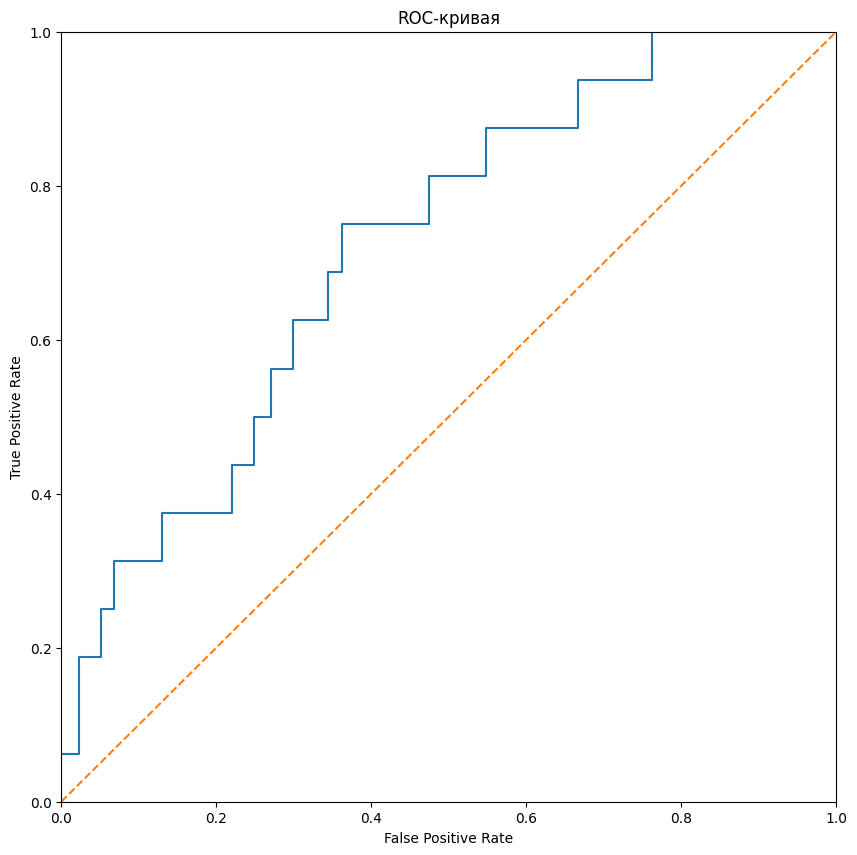

AUC: 0.7192796610169492


In [99]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_test, probabilities)

print("AUC:", auc_roc)

Модель получше константной

## Важность признаков

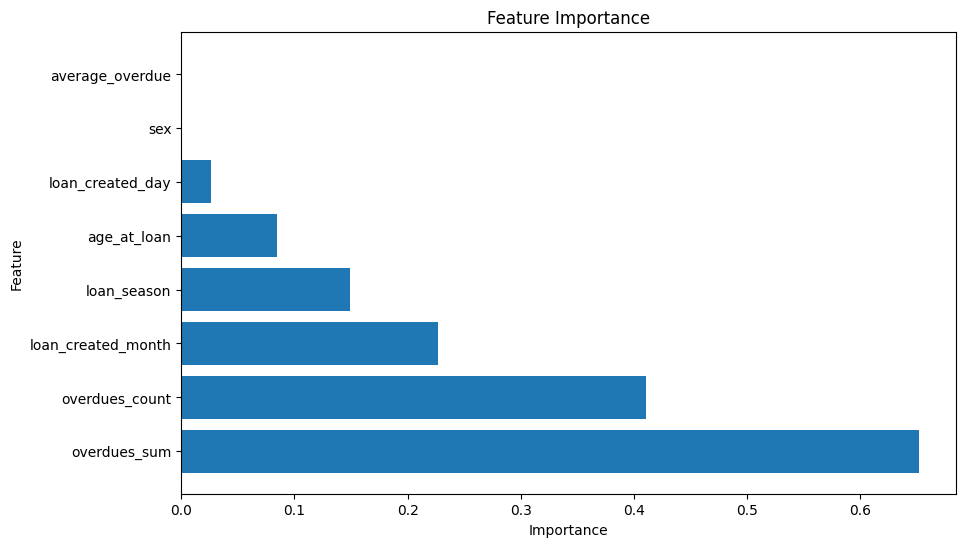

In [100]:
# Получение коэффициентов модели
coefficients = model_best.coef_[0]

# Подсчет абсолютных значений коэффициентов
absolute_coefficients = np.abs(coefficients)

# Создание DataFrame с важностями признаков
feature_importance_df = pd.DataFrame({'Feature': features_train.columns, 'Importance': absolute_coefficients})

# Сортировка по убыванию важности
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Создание графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [101]:
tabl_params

[{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}]

# Вывод 

**Согласно анализу, самые важные признаки, на которые стоит обратить внимание, это:**  
  
1. *overdues_sum*: Общая сумма просроченных дней платежей клиента. Этот признак является сильным индикатором плохой кредитной истории и может быть полезным для прогнозирования типа кредита.  
  
2. *overdues_count*: Количество просроченных платежей клиента. Этот признак указывает на активность клиента в погашении кредитных обязательств и может быть полезным для предсказания типа кредита.  

3. *loan_created_month* Месяц когда был взят кредит. Сезонность влияет на целевой признак.
  
**Для прогнозирования проблемных кредитов можно использовать модель**    
*model_best = LogisticRegression(**grid_search.best_params_, random_state=453, class_weight='balanced')
   
Best parameters: [{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}]*  
 
**С метриками**   

*ROC-AUC: 0.719    
Gini Index: 0.44   
F1-score: 0.23*    

Эти метрики позволяют оценить качество модели и ее способность предсказывать тип кредита.  

***Проблемы построения модели:***  
  
1. Малое количество признаков: У нас ограниченный набор признаков, которые могут быть использованы для построения модели. Это может ограничить способность модели к полному и точному прогнозированию типа кредита. Возможно, добавление дополнительных информативных признаков может улучшить производительность модели.
  
2. Недостаток данных: Если у вас мало данных, особенно примеров положительного класса (в вашем случае - проблемных кредитов), это может затруднить обучение хорошей модели. Модели машинного обучения обычно работают лучше с большим количеством данных. 
   
3. Отсутствие уникального идентификатора кредита: В данных отсутствует прямой способ связать просрочки с конкретными кредитами. Это ограничивает нашу способность более точно анализировать и предсказывать связь между просрочками и типом кредита. Вместо этого мы предполагаем, что общая история просрочек клиента применима ко всем его кредитам. Это может вносить некоторую неопределенность и потенциально снижать точность предсказания модели.  

В целом, необходимо учитывать эти проблемы при построении модели и принимать соответствующие меры для минимизации их влияния на качество и интерпретируемость модели.  

In [102]:
table_models.to_csv('результаты_тестирования.csv', index=False)
